In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3, 3]
import torch
import rising.transforms as rtr
from rising.loading import DataLoader, default_transform_call
from rising.random import DiscreteParameter, UniformParameter
from datetime import datetime

In [2]:
bench_data = np.load('ct_train_1001_image.256256128.npy')
bench_data = np.expand_dims(bench_data, axis=(0))
bench_data = torch.from_numpy(bench_data)
print(bench_data.shape)

torch.Size([1, 256, 256, 128])


## Benchmark Flip

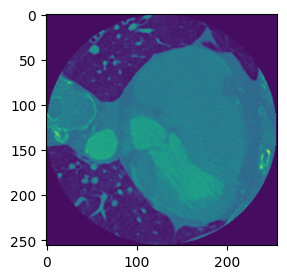

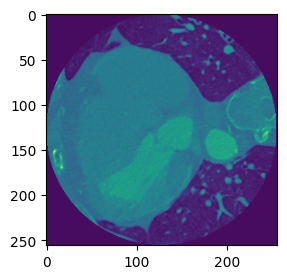

In [3]:
batch = {
    "data": bench_data.to('cuda'),
}
def apply_transform(trafo, batch):
    transformed = trafo(**batch)
    return transformed

flip_transform = rtr.Mirror(dims=(0,),prob = 1.0)
transformed_tensor = flip_transform(**batch)

plt.imshow(bench_data.numpy()[0][:,:,54])
plt.show()
plt.imshow(transformed_tensor['data'].cpu().numpy()[0][:,:,54])
plt.show()

In [4]:
start_time = datetime.now()

for i in range(100000):
    transformed_tensor = flip_transform(**batch)
    
time = datetime.now() - start_time
time = np.timedelta64(time, 'ns')

print(time / 100000)
print((float(time/100000) / 1000000), 'millisec')

149300 nanoseconds
0.1493 millisec


## Benchmark Crop

torch.Size([1, 256, 256, 128])
torch.Size([1, 256, 100, 100])


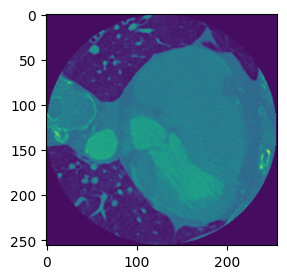

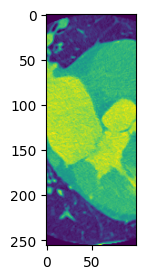

In [5]:
batch = {
    "data": bench_data.to('cuda'),
}
def apply_transform(trafo, batch):
    transformed = trafo(**batch)
    return transformed

print(batch['data'].shape)


crop_transform = rtr.RandomCrop(size=(100,100,200,1,))
transformed_tensor = crop_transform(**batch)

print(transformed_tensor['data'].shape)

plt.imshow(bench_data.numpy()[0][:,:,54])
plt.show()
plt.imshow(transformed_tensor['data'].cpu().numpy()[0][:,:,42])
plt.show()

In [6]:
x = 0

start_time = datetime.now()

for i in range(100000):
    transformed_tensor = crop_transform(**batch)
    x = transformed_tensor['data'][0,0,0]
    
time = datetime.now() - start_time
time = np.timedelta64(time, 'ns')

print(time / 100000)
print((float(time/100000) / 1000000), 'millisec')

97489 nanoseconds
0.097489 millisec


## Benchmark Resize

torch.Size([1, 1, 256, 256, 128])
torch.Size([1, 1, 200, 200, 100])


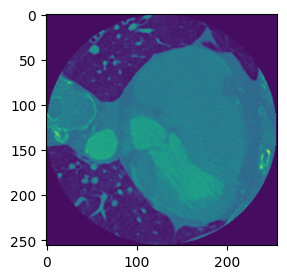

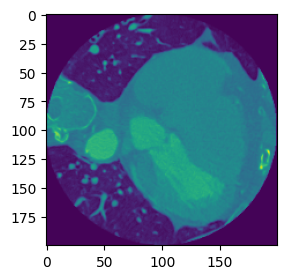

In [7]:
batch = {
    "data": bench_data[None,:,:,:,:].to('cuda'),
}
def apply_transform(trafo, batch):
    transformed = trafo(**batch)
    return transformed

print(batch['data'].shape)


resize_transform = rtr.ResizeNative(size = (200,200,100), mode='trilinear')
transformed_tensor = resize_transform(**batch)

print(transformed_tensor['data'].shape)

plt.imshow(bench_data.numpy()[0][:,:,54])
plt.show()
plt.imshow(transformed_tensor['data'].cpu().numpy()[0,0][:,:,42])
plt.show()


In [8]:
x = 0

start_time = datetime.now()

for i in range(10000):
    transformed_tensor = resize_transform(**batch)
    x = transformed_tensor['data'][0,0,0]
    
    
time = datetime.now() - start_time
time = np.timedelta64(time, 'ns')

print(time / 10000)
print((float(time/10000) / 1000000), 'millisec')

403065 nanoseconds
0.403065 millisec


## Add noise

torch.Size([1, 256, 256, 128])
torch.Size([1, 256, 256, 128])


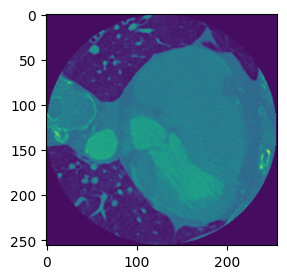

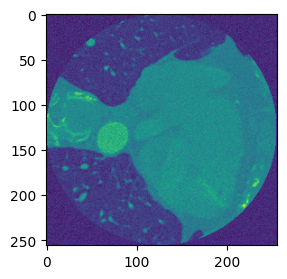

In [9]:
batch = {
    "data": bench_data.to('cuda'),
}
def apply_transform(trafo, batch):
    transformed = trafo(**batch)
    return transformed

print(batch['data'].shape)


noise_transform = rtr.GaussianNoise(0., 100)
transformed_tensor = noise_transform(**batch)

print(transformed_tensor['data'].shape)

plt.imshow(bench_data.numpy()[0][:,:,54])
plt.show()
plt.imshow(transformed_tensor['data'].cpu().numpy()[0][:,:,42])
plt.show()

In [10]:
x = 0

start_time = datetime.now()

for i in range(10000):
    transformed_tensor = noise_transform(**batch)
    x = transformed_tensor['data'][0,0,0]
    
time = datetime.now() - start_time
time = np.timedelta64(time, 'ns')

print(time / 10000)
print((float(time/10000) / 1000000), 'millisec')

987758 nanoseconds
0.987758 millisec


## Add blur

torch.Size([1, 256, 256, 128])
torch.Size([1, 256, 254, 126])


C:\Users\vasiliev\miniconda3\envs\pytorch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


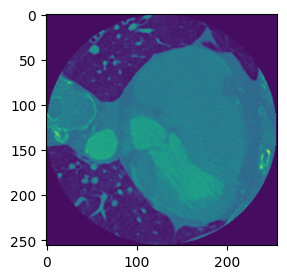

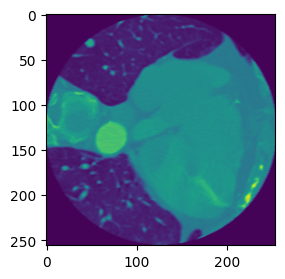

In [11]:
batch = {
    "data": bench_data.float().to('cuda'),
}
def apply_transform(trafo, batch):
    transformed = trafo(**batch)
    return transformed

print(batch['data'].shape)


import math
from typing import Callable, Sequence, Union
from rising.utils import check_scalar
class GaussSmoothing(rtr.KernelTransform):
    """
    Perform Gaussian Smoothing.
    Filtering is performed seperately for each channel in the input using a
    depthwise convolution.
    This code is adapted from:
    'https://discuss.pytorch.org/t/is-there-anyway-to-do-'
    'gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/10'
    """

    def __init__(
        self,
        in_channels: int,
        kernel_size: Union[int, Sequence],
        std: Union[int, Sequence],
        dim: int = 2,
        stride: Union[int, Sequence] = 1,
        padding: Union[int, Sequence] = 0,
        padding_mode: str = "reflect",
        keys: Sequence = ("data",),
        grad: bool = False,
        **kwargs,
    ):
        """
        Args:
            in_channels: number of input channels
            kernel_size: size of kernel
            std: standard deviation of gaussian
            dim: number of spatial dimensions
            stride: stride of convolution
            padding: padding size for input
            padding_mode: padding mode for input. Supports all modes from
                :func:`torch.functional.pad` except ``circular``
            keys: keys which should be augmented
            grad: enable gradient computation inside transformation
            **kwargs: keyword arguments passed to superclass

        See Also:
            :func:`torch.functional.pad`
        """
        if check_scalar(std):
            std = [std] * dim
        self.std = std
        super().__init__(
            in_channels=in_channels,
            kernel_size=kernel_size,
            dim=dim,
            stride=stride,
            padding=padding,
            padding_mode=padding_mode,
            keys=keys,
            grad=grad,
            **kwargs,
        )

    def create_kernel(self) -> torch.Tensor:
        """
        Create gaussian blur kernel
        """
        # The gaussian kernel is the product of the gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in self.kernel_size])

        for size, std, mgrid in zip(self.kernel_size, self.std, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * torch.exp(-(((mgrid - mean) / std) ** 2) / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / kernel.sum()

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(self.in_channels, *[1] * (kernel.dim() - 1))
        kernel.requires_grad = False
        return kernel.contiguous().to('cuda')


blur_transform = GaussSmoothing(in_channels=256, kernel_size=3, std=(100, 200))
transformed_tensor = blur_transform(**batch)

print(transformed_tensor['data'].shape)

plt.imshow(bench_data.numpy()[0][:,:,54])
plt.show()
plt.imshow(transformed_tensor['data'].cpu().numpy()[0][:,:,42])
plt.show()

In [12]:
x = 0

start_time = datetime.now()

for i in range(100000):
    transformed_tensor = blur_transform(**batch)
    x = transformed_tensor['data'][0,0,0]
    
time = datetime.now() - start_time
time = np.timedelta64(time, 'ns')

print(time / 100000)
print((float(time/100000) / 1000000), 'millisec') 

225381 nanoseconds
0.225381 millisec


## Bench rotate

torch.Size([1, 256, 256, 128])
torch.Size([1, 256, 256, 128])


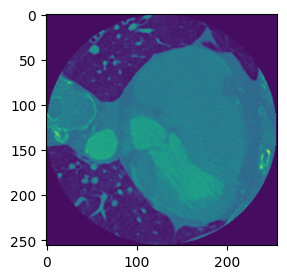

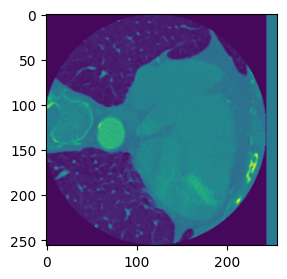

In [13]:
batch = {
    "data": bench_data.float().to('cuda'),
}
def apply_transform(trafo, batch):
    transformed = trafo(**batch)
    return transformed

print(batch['data'].shape)


affine_transform = rtr.BaseAffine(
    scale=UniformParameter(0.9, 1.2),
    rotation=UniformParameter(-10, 10), degree=True)

transformed_tensor = affine_transform(**batch)

print(transformed_tensor['data'].shape)

plt.imshow(bench_data.numpy()[0][:,:,54])
plt.show()
plt.imshow(transformed_tensor['data'].cpu().numpy()[0][:,:,42])
plt.show()

In [14]:
x = 0

start_time = datetime.now()

for i in range(10000):
    transformed_tensor = affine_transform(**batch)
    x = transformed_tensor['data'][0,0,0]
    
time = datetime.now() - start_time
time = np.timedelta64(time, 'ns')

print(time / 10000)
print((float(time/10000) / 1000000), 'millisec')     

1687000 nanoseconds
1.687 millisec
